In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from rpasim.ode import AB
from rpasim.ode.classic_control import PopulationDynamics
from rpasim.plot.ode import plot_trajectory
from rpasim.plot.env import plot_env_trajectory
from rpasim.env import DifferentiableEnv
import matplotlib.pyplot as plt

from rpasim.style import set_style
set_style()

# Test All Implemented ODEs

This notebook plots all implemented ODEs using both:
1. Direct ODE integration (plot_trajectory)
2. Environment simulation (plot_env_trajectory)

In [3]:
# Define ODE configurations
ode_configs = [
    {
        "ode": AB(),
        "x0": torch.tensor([1.0, 1.0]),
        "T": 100.0,
        "reward_fn": lambda state: -torch.norm(state[-1] - 4.0)
    },
    {
        "ode": PopulationDynamics(),
        "x0": torch.tensor([50.0, 10.0]),
        "T": 100.0,
        "reward_fn": lambda state: -torch.norm(state - torch.tensor([100.0, 20.0]))
    }
]


AB (Integral Feedback)
Equations:
  dA/dt = 1.0000 + 0.0000*A + -0.2500*B
  dB/dt = 4.0000*A - 1.0000*B
Parameters:
  alpha1 = 1.0000, alpha2 = 0.0000, alpha3 = -0.2500
  beta1 = 4.0000, beta2 = 1.0000

Direct ODE Integration:


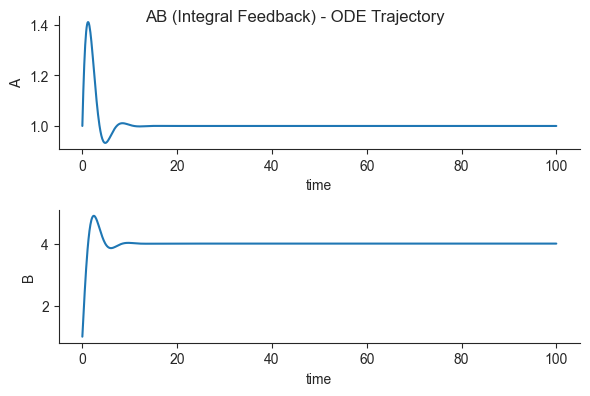


Environment Simulation:


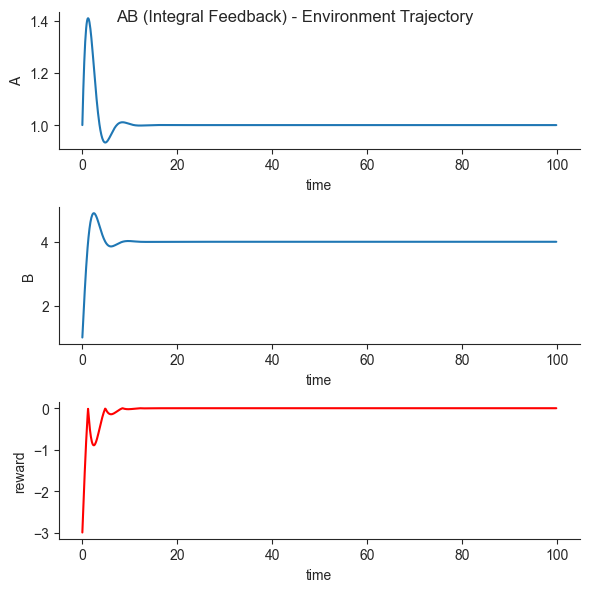


Total reward: -40.68

Population Dynamics (Lotka-Volterra)
Equations:
  dprey/dt = 0.5000*prey - 0.0250*prey*predator
  dpredator/dt = -0.5000*predator + 0.0050*prey*predator
Parameters:
  a = 0.5000, b = 0.0250, c = 0.5000, d = 0.0050

Direct ODE Integration:


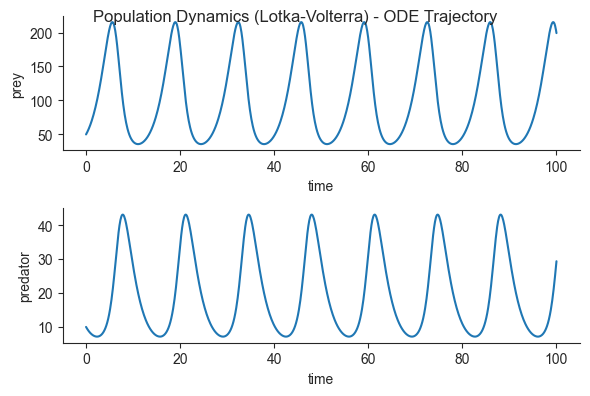


Environment Simulation:


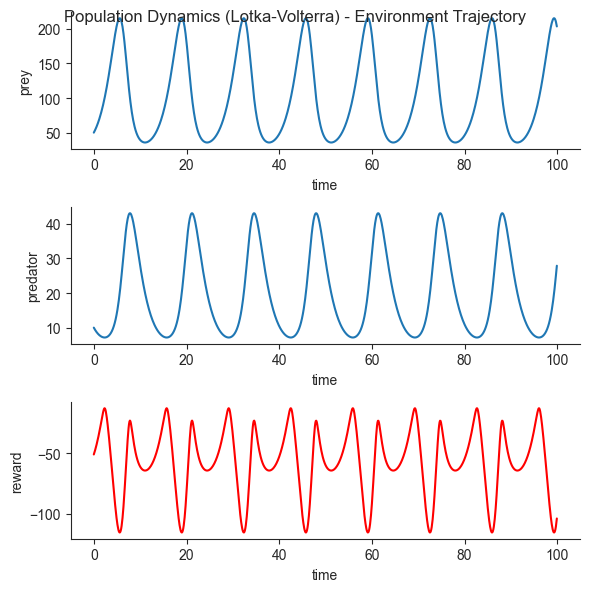


Total reward: -56441.86


In [4]:
# Plot all ODEs
for config in ode_configs:
    print(f"\n{'='*60}")
    print(config['ode'])
    print(f"{'='*60}")
    
    # 1. Plot using ODE trajectory
    print("\nDirect ODE Integration:")
    fig, axes = plot_trajectory(
        config['ode'],
        config['x0'],
        config['T'],
        n_steps=1000
    )
    fig.suptitle(f"{config['ode'].name} - ODE Trajectory")
    plt.show()
    
    # 2. Plot using environment
    print("\nEnvironment Simulation:")
    env = DifferentiableEnv(
        initial_ode=config['ode'],
        reward_fn=config['reward_fn'],
        initial_state=config['x0'],
        time_horizon=config['T']
    )
    
    # Run environment
    env.reset()
    env.step((config['ode'], config['T']))
    
    # Plot
    fig, axes = plot_env_trajectory(env)
    fig.suptitle(f"{config['ode'].name} - Environment Trajectory")
    plt.show()
    
    print(f"\nTotal reward: {env.get_trajectory()[2].sum():.2f}")